# NumPy 實戰小專案：用 NumPy 做台股 / 美股股價資料分析

## 學習目標

本專案將帶你完成一個真實的股價資料分析流程，學習：

- **理解 OHLCV + Date 作為真實世界的資料格式**
  - Open（開盤）、High（最高）、Low（最低）、Close（收盤）、Volume（成交量）
  - 加上日期欄位，形成完整的時間序列資料

- **建立 30 個交易日資料（跳過週末）**
  - 模擬真實交易日曆（週一到週五）
  - 使用 Python datetime 模組處理日期

- **用 NumPy 儲存和載入 CSV（混合型別資料）**
  - 處理日期字串與數值混合的資料
  - 學習 np.savetxt 和 np.genfromtxt 的使用技巧

- **分析收盤價、成交量、報酬率、波動率**
  - 運用向量化運算進行統計分析
  - 找出關鍵交易日和市場特徵

## 專案特色

- ✅ **純 NumPy 實作**：不使用 pandas，深入理解底層運作
- ✅ **真實場景模擬**：交易日、CSV 儲存、混合型別處理
- ✅ **完整工作流程**：從資料建立 → 儲存 → 載入 → 分析 → 視覺化

## 環境設定

In [13]:
# 匯入必要套件
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta
import os

# 設定 NumPy 輸出格式（不使用科學記號，保留 4 位小數）
np.set_printoptions(suppress=True, precision=4)

print("✅ 環境設定完成！")
print(f"NumPy 版本：{np.__version__}")

✅ 環境設定完成！
NumPy 版本：2.0.2


## Section A — 建立交易日日期清單

### 為什麼要跳過週末？

在真實的股票市場中，**只有週一到週五是交易日**，週六日市場休市。因此我們需要模擬這個特性。

### 實作策略

1. 設定一個固定的起始日期（例如 2025-01-02，週四）
2. 逐日往後推進，只保留週一到週五
3. 收集到 30 個交易日為止
4. 將日期以 `"YYYY-MM-DD"` 字串格式存入 NumPy 陣列

In [14]:
# 步驟 1：設定起始日期（2025-01-02 是週四）
start_date = date(2025, 1, 2)
print(f"起始日期：{start_date} ({start_date.strftime('%A')})")  # 顯示星期幾

# 步驟 2：建立空的日期清單
trading_dates = []

# 步驟 3：迴圈產生交易日（只要週一到週五）
current_date = start_date
while len(trading_dates) < 30:
    # weekday() 回傳 0=週一, 1=週二, ..., 6=週日
    # 只有 0-4 (週一到週五) 才是交易日
    if current_date.weekday() < 5:  # 0, 1, 2, 3, 4 代表週一到週五
        # 將日期轉成字串格式 "YYYY-MM-DD" 並加入清單
        trading_dates.append(current_date.strftime("%Y-%m-%d"))
    
    # 往後推一天
    current_date += timedelta(days=1)

# 步驟 4：轉換成 NumPy 陣列
dates = np.array(trading_dates, dtype=str)

# 驗證結果
print(f"\n✅ 成功產生 {len(dates)} 個交易日")
print(f"日期陣列形狀：{dates.shape}")
print(f"\n前 5 個交易日：")
for i, d in enumerate(dates[:5]):
    # 將字串轉回 date 物件以顯示星期幾
    date_obj = date.fromisoformat(d)
    print(f"  {i+1}. {d} ({date_obj.strftime('%A')})")  

print(f"\n最後一個交易日：{dates[-1]}")

起始日期：2025-01-02 (Thursday)

✅ 成功產生 30 個交易日
日期陣列形狀：(30,)

前 5 個交易日：
  1. 2025-01-02 (Thursday)
  2. 2025-01-03 (Friday)
  3. 2025-01-06 (Monday)
  4. 2025-01-07 (Tuesday)
  5. 2025-01-08 (Wednesday)

最後一個交易日：2025-02-12


## Section B — 建立模擬 OHLCV 資料

### OHLCV 欄位說明

股價資料通常包含五個關鍵欄位：

- **Open（開盤價）**：當日開盤時的第一筆成交價
- **High（最高價）**：當日的最高成交價
- **Low（最低價）**：當日的最低成交價
- **Close（收盤價）**：當日收盤時的最後一筆成交價（最常用於分析）
- **Volume（成交量）**：當日的總成交股數

### 模擬策略

我們使用隨機數產生合理的股價資料：
- 開盤價在 140-150 之間
- 最高價 = 開盤價 + 隨機漲幅（0-5）
- 最低價 = 開盤價 - 隨機跌幅（0-5）
- 收盤價在最低價與最高價之間
- 成交量在 10,000-50,000 之間

In [15]:
# 步驟 1：設定隨機種子（確保每次執行結果相同，方便教學）
np.random.seed(42)
print("✅ 隨機種子已設定（seed=42）")

# 步驟 2：產生開盤價（140-150 之間的 30 個隨機數）
open_price = np.random.uniform(140, 150, 30)
print(f"\n開盤價範圍：{open_price.min():.2f} ~ {open_price.max():.2f}")

# 步驟 3：產生最高價（開盤價 + 0~5 的隨機漲幅）
high_price = open_price + np.random.uniform(0, 5, 30)
print(f"最高價範圍：{high_price.min():.2f} ~ {high_price.max():.2f}")

# 步驟 4：產生最低價（開盤價 - 0~5 的隨機跌幅）
low_price = open_price - np.random.uniform(0, 5, 30)
print(f"最低價範圍：{low_price.min():.2f} ~ {low_price.max():.2f}")

# 步驟 5：產生收盤價（在最低價與最高價之間）
# 使用向量化運算：對每個交易日，在其 low 和 high 之間隨機取值
close_price = np.array([np.random.uniform(low, high) 
                        for low, high in zip(low_price, high_price)])
print(f"收盤價範圍：{close_price.min():.2f} ~ {close_price.max():.2f}")

# 步驟 6：產生成交量（10,000-50,000 之間的整數）
volume = np.random.randint(10000, 50000, 30)
print(f"成交量範圍：{volume.min():,} ~ {volume.max():,}")

# 步驟 7：組合成 OHLCV 二維陣列（30 列 x 5 欄）
# np.column_stack 會把多個一維陣列垂直堆疊成二維陣列
ohlcv = np.column_stack([open_price, high_price, low_price, close_price, volume])

# 驗證結果
print(f"\n✅ OHLCV 資料建立完成")
print(f"形狀：{ohlcv.shape}（{ohlcv.shape[0]} 個交易日 x {ohlcv.shape[1]} 個欄位）")
print(f"資料型別：{ohlcv.dtype}")
print(f"\n前 3 天的資料：")
print("     Open      High       Low     Close    Volume")
for i in range(3):
    print(f"{i+1}. {ohlcv[i,0]:8.2f} {ohlcv[i,1]:9.2f} {ohlcv[i,2]:9.2f} {ohlcv[i,3]:9.2f} {ohlcv[i,4]:10.0f}")

✅ 隨機種子已設定（seed=42）

開盤價範圍：140.21 ~ 149.70
最高價範圍：140.82 ~ 152.46
最低價範圍：136.34 ~ 148.71
收盤價範圍：136.49 ~ 151.66
成交量範圍：10,663 ~ 49,353

✅ OHLCV 資料建立完成
形狀：(30, 5)（30 個交易日 x 5 個欄位）
資料型別：float64

前 3 天的資料：
     Open      High       Low     Close    Volume
1.   143.75    146.78    141.80    142.40      36105
2.   149.51    150.36    148.15    149.73      20230
3.   147.32    147.65    143.18    146.58      25707


## Section C — 儲存 Date + OHLCV 到 CSV 檔案

### 為什麼要儲存 CSV？

CSV（Comma-Separated Values）是最常見的資料交換格式：
- 人類可讀、易於分享
- 各種程式語言和工具都支援
- Excel 可以直接開啟

### 挑戰：處理混合型別

我們的資料包含：
- **日期**：字串型別（`"2025-01-02"`）
- **OHLCV**：浮點數和整數

NumPy 的解決方案：使用 **object 型別陣列**暫存，然後用 `np.savetxt` 儲存。

### 格式化輸出

使用 `fmt` 參數控制每欄的格式：
- `%s`：字串（日期）
- `%.4f`：浮點數，保留 4 位小數（OHLC）
- `%d`：整數（Volume）

In [16]:
# 步驟 1：建立一個 object 型別的二維陣列（30 列 x 6 欄）
# 用 object 型別是因為要同時存字串（日期）和數值（OHLCV）
data_to_save = np.empty((30, 6), dtype=object)
print(f"建立暫存陣列：{data_to_save.shape}")

# 步驟 2：填入資料
data_to_save[:, 0] = dates          # 第 0 欄：日期（字串）
data_to_save[:, 1] = open_price     # 第 1 欄：開盤價
data_to_save[:, 2] = high_price     # 第 2 欄：最高價
data_to_save[:, 3] = low_price      # 第 3 欄：最低價
data_to_save[:, 4] = close_price    # 第 4 欄：收盤價
data_to_save[:, 5] = volume         # 第 5 欄：成交量

print("✅ 資料已填入暫存陣列")
print("前 2 列：")
print(data_to_save[:2])

# 步驟 3：定義檔案路徑和確保目錄存在
csv_filepath = "lesson_15_16_numpy/stock_ohlcv_30d_with_date.csv"

# 確保目錄存在（如果不存在則建立）
os.makedirs("lesson_15_16_numpy", exist_ok=True)
print(f"\n✅ 確認目錄存在：lesson_15_16_numpy/")

# 步驟 4：使用 np.savetxt 儲存
np.savetxt(
    csv_filepath,
    data_to_save,
    delimiter=",",                    # 用逗號分隔
    header="Date,Open,High,Low,Close,Volume",  # 欄位名稱
    comments="",                      # 不加註解符號（預設是 #）
    fmt=["%s", "%.4f", "%.4f", "%.4f", "%.4f", "%d"]  # 每欄的格式
)

print(f"\n✅ CSV 檔案已成功儲存！")
print(f"檔案路徑：{csv_filepath}")

# 步驟 5：讀取檔案內容並顯示前 5 行（驗證）
print(f"\n📄 檔案內容（前 5 行）：")
print("=" * 60)
with open(csv_filepath, 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines[:6]):  # header + 前 5 筆資料
        print(line.strip())

建立暫存陣列：(30, 6)
✅ 資料已填入暫存陣列
前 2 列：
[['2025-01-02' 143.74540118847364 146.78312544798084 141.80201474002624
  142.39772691907928 36105]
 ['2025-01-03' 149.50714306409915 150.3597636825356 148.15039790522968
  149.726216528962 20230]]

✅ 確認目錄存在：lesson_15_16_numpy/

✅ CSV 檔案已成功儲存！
檔案路徑：lesson_15_16_numpy/stock_ohlcv_30d_with_date.csv

📄 檔案內容（前 5 行）：
Date,Open,High,Low,Close,Volume
2025-01-02,143.7454,146.7831,141.8020,142.3977,36105
2025-01-03,149.5071,150.3598,148.1504,149.7262,20230
2025-01-06,147.3199,147.6452,143.1763,146.5762,25707
2025-01-07,145.9866,150.7310,144.2028,147.8669,31976
2025-01-08,141.5602,146.3883,140.1555,144.9608,33776


## Section D — 用 NumPy 載入 CSV（混合型別）

### 為什麼 dtype 很重要？

當 CSV 包含不同型別的資料時，NumPy 需要知道如何解析：
- **dtype=None**：自動推斷每欄的型別
- **encoding="utf-8"**：處理中文等特殊字元
- **skip_header=1**：跳過標題列

### np.genfromtxt 的行為

`np.genfromtxt` 在處理混合型別時，可能回傳：
1. **結構化陣列（structured array）**：每欄有獨立的 dtype
2. **二維 object 陣列**：所有元素都是 object

我們需要處理這兩種情況。

In [17]:
# 步驟 1：使用 np.genfromtxt 載入 CSV
print(f"📂 正在載入：{csv_filepath}")

loaded_data = np.genfromtxt(
    csv_filepath,
    delimiter=",",      # 用逗號分隔
    skip_header=1,      # 跳過第一行（欄位名稱）
    dtype=None,         # 自動推斷型別
    encoding="utf-8"    # 處理 UTF-8 編碼
)

print(f"✅ 載入完成！")
print(f"載入資料的型別：{type(loaded_data)}")
print(f"載入資料的 dtype：{loaded_data.dtype}")
print(f"載入資料的形狀：{loaded_data.shape}")

# 步驟 2：顯示前 3 筆資料
print(f"\n前 3 筆資料：")
print(loaded_data[:3])

# 步驟 3：檢查是否為結構化陣列
if loaded_data.dtype.names is not None:
    print(f"\n📊 這是結構化陣列（structured array）")
    print(f"欄位名稱：{loaded_data.dtype.names}")
else:
    print(f"\n📊 這是一般陣列（可能是二維 object 陣列）")

📂 正在載入：lesson_15_16_numpy/stock_ohlcv_30d_with_date.csv
✅ 載入完成！
載入資料的型別：<class 'numpy.ndarray'>
載入資料的 dtype：[('f0', '<U10'), ('f1', '<f8'), ('f2', '<f8'), ('f3', '<f8'), ('f4', '<f8'), ('f5', '<i8')]
載入資料的形狀：(30,)

前 3 筆資料：
[('2025-01-02', 143.7454, 146.7831, 141.802 , 142.3977, 36105)
 ('2025-01-03', 149.5071, 150.3598, 148.1504, 149.7262, 20230)
 ('2025-01-06', 147.3199, 147.6452, 143.1763, 146.5762, 25707)]

📊 這是結構化陣列（structured array）
欄位名稱：('f0', 'f1', 'f2', 'f3', 'f4', 'f5')


## Section E — 分離日期與數值陣列

### 為什麼要分離？

為了方便後續分析，我們需要：
- **dates_loaded**：純字串陣列，方便顯示日期
- **ohlcv_loaded**：純數值陣列（float），方便數學運算

### 處理策略

我們需要處理 `genfromtxt` 可能回傳的兩種格式：

1. **結構化陣列**：
   - 使用欄位名稱存取（如 `loaded_data['f0']`）
   - 需要用 `np.column_stack` 組合數值欄位

2. **二維陣列**：
   - 使用索引存取（如 `loaded_data[:, 0]`）
   - 直接切片即可

我們的程式會自動偵測並處理。

In [18]:
# 步驟 1：偵測 loaded_data 的類型並分離資料
print("🔍 開始分離日期與數值資料...\n")

if loaded_data.dtype.names is not None:
    # 情況 1：結構化陣列
    print("✓ 偵測到結構化陣列格式")
    
    # 提取日期（第一個欄位 'f0'）
    dates_loaded = loaded_data['f0'].astype(str)
    
    # 提取數值欄位（'f1' 到 'f5'）並組合成二維陣列
    ohlcv_loaded = np.column_stack([
        loaded_data['f1'],  # Open
        loaded_data['f2'],  # High
        loaded_data['f3'],  # Low
        loaded_data['f4'],  # Close
        loaded_data['f5']   # Volume
    ]).astype(float)
    
else:
    # 情況 2：二維陣列（object 或其他）
    print("✓ 偵測到二維陣列格式")
    
    # 提取日期（第 0 欄）
    dates_loaded = loaded_data[:, 0].astype(str)
    
    # 提取數值欄位（第 1-5 欄）
    ohlcv_loaded = loaded_data[:, 1:].astype(float)

# 步驟 2：驗證結果
print(f"\n✅ 分離完成！")
print(f"\n📅 日期陣列：")
print(f"   形狀：{dates_loaded.shape}")
print(f"   型別：{dates_loaded.dtype}")
print(f"   前 3 筆：{dates_loaded[:3]}")

print(f"\n📊 OHLCV 數值陣列：")
print(f"   形狀：{ohlcv_loaded.shape}")
print(f"   型別：{ohlcv_loaded.dtype}")
print(f"   前 3 筆：")
print("     Open      High       Low     Close    Volume")
for i in range(3):
    print(f"{i+1}. {ohlcv_loaded[i,0]:8.2f} {ohlcv_loaded[i,1]:9.2f} {ohlcv_loaded[i,2]:9.2f} {ohlcv_loaded[i,3]:9.2f} {ohlcv_loaded[i,4]:10.0f}")

🔍 開始分離日期與數值資料...

✓ 偵測到結構化陣列格式

✅ 分離完成！

📅 日期陣列：
   形狀：(30,)
   型別：<U10
   前 3 筆：['2025-01-02' '2025-01-03' '2025-01-06']

📊 OHLCV 數值陣列：
   形狀：(30, 5)
   型別：float64
   前 3 筆：
     Open      High       Low     Close    Volume
1.   143.75    146.78    141.80    142.40      36105
2.   149.51    150.36    148.15    149.73      20230
3.   147.32    147.65    143.18    146.58      25707


## Section F — 用 NumPy 進行股價分析

現在我們有乾淨的資料了，開始進行各種分析！

分析內容：
1. 提取收盤價與成交量
2. 計算收盤價的基本統計
3. 找出最佳 / 最差交易日
4. 計算每日報酬率
5. 識別高波動日

### F1. 提取收盤價與成交量

In [19]:
# OHLCV 欄位順序：0=Open, 1=High, 2=Low, 3=Close, 4=Volume

# 提取收盤價（第 3 欄）
close = ohlcv_loaded[:, 3]
print("📈 收盤價（前 5 天）：")
for i in range(5):
    print(f"   {dates_loaded[i]}: {close[i]:.2f}")

# 提取成交量（第 4 欄）
volume = ohlcv_loaded[:, 4]
print("\n📊 成交量（前 5 天）：")
for i in range(5):
    print(f"   {dates_loaded[i]}: {volume[i]:,.0f}")

📈 收盤價（前 5 天）：
   2025-01-02: 142.40
   2025-01-03: 149.73
   2025-01-06: 146.58
   2025-01-07: 147.87
   2025-01-08: 144.96

📊 成交量（前 5 天）：
   2025-01-02: 36,105
   2025-01-03: 20,230
   2025-01-06: 25,707
   2025-01-07: 31,976
   2025-01-08: 33,776


### F2. 收盤價基本統計

In [20]:
# 計算統計指標（使用 NumPy 的聚合函數）
avg_close = close.mean()
max_close = close.max()
min_close = close.min()
std_close = close.std()

print("📊 收盤價統計摘要")
print("=" * 40)
print(f"平均收盤價：{avg_close:8.2f}")
print(f"最高收盤價：{max_close:8.2f}")
print(f"最低收盤價：{min_close:8.2f}")
print(f"標準差：    {std_close:8.2f}")
print(f"價格區間：  {max_close - min_close:8.2f}")

📊 收盤價統計摘要
平均收盤價：  144.38
最高收盤價：  151.66
最低收盤價：  136.49
標準差：        3.50
價格區間：     15.17


### F3. 找出最佳 / 最差交易日

使用 `np.argmax` 和 `np.argmin` 找出索引值，再對應到日期。

In [21]:
# 找出最佳交易日（收盤價最高）
best_idx = np.argmax(close)
best_date = dates_loaded[best_idx]
best_close = close[best_idx]

print("🏆 最佳交易日")
print(f"   日期：{best_date}")
print(f"   收盤價：{best_close:.2f}")
print(f"   索引位置：第 {best_idx + 1} 天")

# 找出最差交易日（收盤價最低）
worst_idx = np.argmin(close)
worst_date = dates_loaded[worst_idx]
worst_close = close[worst_idx]

print("\n📉 最差交易日")
print(f"   日期：{worst_date}")
print(f"   收盤價：{worst_close:.2f}")
print(f"   索引位置：第 {worst_idx + 1} 天")

# 計算價差
print(f"\n💡 兩者價差：{best_close - worst_close:.2f}（{((best_close - worst_close) / worst_close * 100):.2f}%）")

🏆 最佳交易日
   日期：2025-02-06
   收盤價：151.66
   索引位置：第 26 天

📉 最差交易日
   日期：2025-01-16
   收盤價：136.49
   索引位置：第 11 天

💡 兩者價差：15.17（11.12%）


### F4. 計算每日報酬率（向量化運算）

**報酬率公式**：
$$
\text{Return}_t = \frac{\text{Close}_t - \text{Close}_{t-1}}{\text{Close}_{t-1}}
$$

使用 NumPy 的**切片技巧**，一行完成所有計算！

In [22]:
# 向量化計算每日報酬率
# close[1:] 是今日收盤價（從第 2 天開始）
# close[:-1] 是昨日收盤價（到倒數第 2 天）
daily_return = (close[1:] - close[:-1]) / close[:-1]

print(f"📈 每日報酬率計算完成")
print(f"報酬率陣列長度：{len(daily_return)}（比原始資料少 1 天）\n")

# 顯示前 5 天的報酬率
print("前 5 天的報酬率：")
for i in range(5):
    # 注意：daily_return[i] 對應的是 dates_loaded[i+1]（第 i+1 天相對於第 i 天的報酬）
    print(f"   {dates_loaded[i]} → {dates_loaded[i+1]}: {daily_return[i]:7.4f} ({daily_return[i]*100:6.2f}%)")

# 計算報酬率統計
print(f"\n📊 報酬率統計")
print("=" * 40)
print(f"平均日報酬率：{daily_return.mean():7.4f} ({daily_return.mean()*100:6.2f}%)")
print(f"報酬率標準差：{daily_return.std():7.4f} ({daily_return.std()*100:6.2f}%)")
print(f"最大日報酬率：{daily_return.max():7.4f} ({daily_return.max()*100:6.2f}%)")
print(f"最小日報酬率：{daily_return.min():7.4f} ({daily_return.min()*100:6.2f}%)")

📈 每日報酬率計算完成
報酬率陣列長度：29（比原始資料少 1 天）

前 5 天的報酬率：
   2025-01-02 → 2025-01-03:  0.0515 (  5.15%)
   2025-01-03 → 2025-01-06: -0.0210 ( -2.10%)
   2025-01-06 → 2025-01-07:  0.0088 (  0.88%)
   2025-01-07 → 2025-01-08: -0.0197 ( -1.97%)
   2025-01-08 → 2025-01-09: -0.0192 ( -1.92%)

📊 報酬率統計
平均日報酬率： 0.0001 (  0.01%)
報酬率標準差： 0.0353 (  3.53%)
最大日報酬率： 0.1057 ( 10.57%)
最小日報酬率：-0.0661 ( -6.61%)


### F5. 識別高波動日

**定義高波動**：報酬率的絕對值超過標準差的日子。

使用 `np.where` 找出符合條件的索引，再對應到日期。

In [23]:
# 步驟 1：計算報酬率的標準差（波動率指標）
return_std = daily_return.std()
print(f"📊 報酬率標準差（波動率）：{return_std:.4f} ({return_std*100:.2f}%)\n")

# 步驟 2：找出高波動日的索引
# np.abs() 取絕對值，因為大漲大跌都算高波動
# np.where() 回傳符合條件的索引（以 tuple 形式，取 [0] 得到陣列）
high_vol_idx = np.where(np.abs(daily_return) > return_std)[0]

print(f"🔥 高波動日數量：{len(high_vol_idx)} / {len(daily_return)}")

# 步驟 3：顯示高波動日的詳細資訊
if len(high_vol_idx) > 0:
    print(f"\n高波動日明細：")
    print("=" * 60)
    for idx in high_vol_idx:
        # 注意：daily_return[idx] 對應的是第 idx+1 天的報酬
        # 因為 daily_return[0] = (close[1] - close[0]) / close[0]
        date_from = dates_loaded[idx]
        date_to = dates_loaded[idx + 1]
        ret = daily_return[idx]
        close_from = close[idx]
        close_to = close[idx + 1]
        
        # 判斷是漲還是跌
        direction = "📈 大漲" if ret > 0 else "📉 大跌"
        
        print(f"{direction} | {date_from} → {date_to}")
        print(f"         報酬率：{ret:7.4f} ({ret*100:6.2f}%)")
        print(f"         收盤價：{close_from:.2f} → {close_to:.2f}")
        print()
else:
    print("沒有檢測到高波動日。")

# 步驟 4：統計高波動日的日期（對應到收盤日）
high_vol_dates = dates_loaded[high_vol_idx + 1]
print(f"\n📅 高波動日期列表（共 {len(high_vol_dates)} 天）：")
print(high_vol_dates)

📊 報酬率標準差（波動率）：0.0353 (3.53%)

🔥 高波動日數量：10 / 29

高波動日明細：
📈 大漲 | 2025-01-02 → 2025-01-03
         報酬率： 0.0515 (  5.15%)
         收盤價：142.40 → 149.73

📈 大漲 | 2025-01-10 → 2025-01-13
         報酬率： 0.0392 (  3.92%)
         收盤價：141.04 → 146.57

📉 大跌 | 2025-01-15 → 2025-01-16
         報酬率：-0.0450 ( -4.50%)
         收盤價：142.92 → 136.49

📈 大漲 | 2025-01-16 → 2025-01-17
         報酬率： 0.1057 ( 10.57%)
         收盤價：136.49 → 150.91

📉 大跌 | 2025-01-20 → 2025-01-21
         報酬率：-0.0400 ( -4.00%)
         收盤價：148.36 → 142.43

📈 大漲 | 2025-01-24 → 2025-01-27
         報酬率： 0.0404 (  4.04%)
         收盤價：141.41 → 147.12

📈 大漲 | 2025-01-31 → 2025-02-03
         報酬率： 0.0557 (  5.57%)
         收盤價：139.41 → 147.17

📈 大漲 | 2025-02-05 → 2025-02-06
         報酬率： 0.0396 (  3.96%)
         收盤價：145.88 → 151.66

📉 大跌 | 2025-02-06 → 2025-02-07
         報酬率：-0.0661 ( -6.61%)
         收盤價：151.66 → 141.64

📉 大跌 | 2025-02-11 → 2025-02-12
         報酬率：-0.0370 ( -3.70%)
         收盤價：145.65 → 140.25


📅 高波動日期列表（共 10 天）：
['20

## Section G — 小試身手（學生練習）

### 練習任務

使用上面載入的 `ohlcv_loaded`、`close`、`volume`、`daily_return` 等資料，完成以下四個任務：

---

#### **任務 1：計算平均成交量**
使用 NumPy 計算 30 天的平均成交量。

---

#### **任務 2：找出高於平均收盤價的天數**
有多少天的收盤價高於 30 天的平均收盤價？

---

#### **任務 3：找出最大單日漲幅（%）**
在 `daily_return` 中找出最大的正報酬率，並轉換成百分比。

---

#### **任務 4：找出成交量最高的交易日**
回傳：
- 索引位置（第幾天）
- 日期
- 成交量

---

### 解題提示（老師用）

- **任務 1**：`np.mean(volume)` 或 `volume.mean()`
- **任務 2**：
  - 先計算平均：`avg_close = close.mean()`
  - 布林遮罩：`close > avg_close`
  - 計數：`.sum()` 會把 True 當作 1
- **任務 3**：
  - `daily_return.max()`
  - 乘以 100 轉成百分比
- **任務 4**：
  - `np.argmax(volume)` 得到索引
  - 用索引去 `dates_loaded` 和 `volume` 取值

---

### 💡 提示

請在下方新增 code cell 完成練習，或參考下一個 cell 的註解解法。

In [24]:
# 在這裡寫下你的解答

# 任務 1：平均成交量


# 任務 2：高於平均收盤價的天數


# 任務 3：最大單日漲幅


# 任務 4：成交量最高的交易日

## Section H — 參考解法（僅供教學參考）

以下解法被包在三引號字串中，**預設不會執行**。

老師可以在課堂上選擇性地取消註解來示範。

In [25]:
# 參考解法（請學員先自行嘗試後再看）
"""
print("="*60)
print("📝 參考解法")
print("="*60)

# ========================================
# 任務 1：計算平均成交量
# ========================================
avg_volume = volume.mean()
print(f"\n✅ 任務 1：平均成交量")
print(f"   平均成交量：{avg_volume:,.2f} 股")

# ========================================
# 任務 2：找出高於平均收盤價的天數
# ========================================
# 先算平均收盤價
avg_close_price = close.mean()

# 建立布林遮罩
above_avg_mask = close > avg_close_price

# 計數（True 會被當作 1）
above_avg_count = above_avg_mask.sum()

print(f"\n✅ 任務 2：高於平均收盤價的天數")
print(f"   平均收盤價：{avg_close_price:.2f}")
print(f"   高於平均天數：{above_avg_count} / {len(close)} 天")
print(f"   比例：{above_avg_count / len(close) * 100:.1f}%")

# ========================================
# 任務 3：找出最大單日漲幅（%）
# ========================================
max_daily_return = daily_return.max()
max_return_pct = max_daily_return * 100

# 找出是哪一天
max_return_idx = np.argmax(daily_return)
max_return_date_from = dates_loaded[max_return_idx]
max_return_date_to = dates_loaded[max_return_idx + 1]

print(f"\n✅ 任務 3：最大單日漲幅")
print(f"   最大漲幅：{max_return_pct:.2f}%")
print(f"   發生日期：{max_return_date_from} → {max_return_date_to}")
print(f"   收盤價變化：{close[max_return_idx]:.2f} → {close[max_return_idx + 1]:.2f}")

# ========================================
# 任務 4：找出成交量最高的交易日
# ========================================
max_vol_idx = np.argmax(volume)
max_vol_date = dates_loaded[max_vol_idx]
max_vol_value = volume[max_vol_idx]

print(f"\n✅ 任務 4：成交量最高的交易日")
print(f"   索引位置：第 {max_vol_idx + 1} 天")
print(f"   日期：{max_vol_date}")
print(f"   成交量：{max_vol_value:,.0f} 股")
print(f"   該日收盤價：{close[max_vol_idx]:.2f}")

print("\n" + "="*60)
print("🎉 所有任務完成！")
print("="*60)
"""

'\nprint("="*60)\nprint("📝 參考解法")\nprint("="*60)\n\n# ========================================\n# 任務 1：計算平均成交量\n# ========================================\navg_volume = volume.mean()\nprint(f"\n✅ 任務 1：平均成交量")\nprint(f"   平均成交量：{avg_volume:,.2f} 股")\n\n# ========================================\n# 任務 2：找出高於平均收盤價的天數\n# ========================================\n# 先算平均收盤價\navg_close_price = close.mean()\n\n# 建立布林遮罩\nabove_avg_mask = close > avg_close_price\n\n# 計數（True 會被當作 1）\nabove_avg_count = above_avg_mask.sum()\n\nprint(f"\n✅ 任務 2：高於平均收盤價的天數")\nprint(f"   平均收盤價：{avg_close_price:.2f}")\nprint(f"   高於平均天數：{above_avg_count} / {len(close)} 天")\nprint(f"   比例：{above_avg_count / len(close) * 100:.1f}%")\n\n# ========================================\n# 任務 3：找出最大單日漲幅（%）\n# ========================================\nmax_daily_return = daily_return.max()\nmax_return_pct = max_daily_return * 100\n\n# 找出是哪一天\nmax_return_idx = np.argmax(daily_return)\nmax_return_date_from = dates_loaded[max_return_

## Section I — 視覺化（選用）

用 Matplotlib 繪製簡單圖表，讓分析結果更直觀！

### 圖表 1：收盤價走勢圖

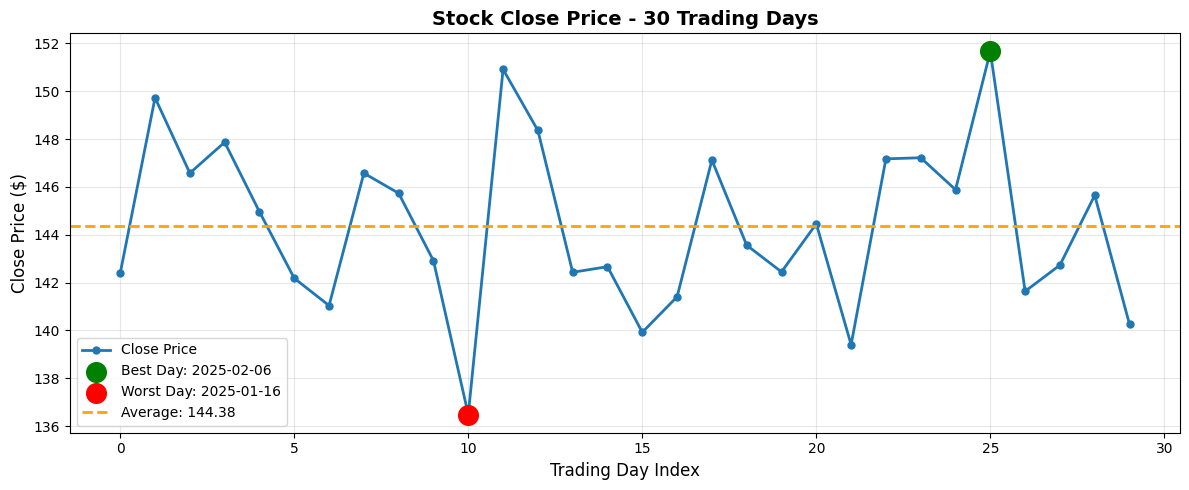

✅ 收盤價走勢圖繪製完成！


In [26]:
# 建立圖表
plt.figure(figsize=(12, 5))

# 繪製收盤價折線圖
plt.plot(range(len(close)), close, marker='o', linewidth=2, markersize=5, label='Close Price')

# 標記最高點和最低點
best_idx = np.argmax(close)
worst_idx = np.argmin(close)

plt.scatter(best_idx, close[best_idx], color='green', s=200, zorder=5, label=f'Best Day: {dates_loaded[best_idx]}')
plt.scatter(worst_idx, close[worst_idx], color='red', s=200, zorder=5, label=f'Worst Day: {dates_loaded[worst_idx]}')

# 加上平均線
plt.axhline(y=close.mean(), color='orange', linestyle='--', linewidth=2, label=f'Average: {close.mean():.2f}')

# 設定標題和標籤
plt.title('Stock Close Price - 30 Trading Days', fontsize=14, fontweight='bold')
plt.xlabel('Trading Day Index', fontsize=12)
plt.ylabel('Close Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print("✅ 收盤價走勢圖繪製完成！")

### 圖表 2：每日報酬率分佈（直方圖）

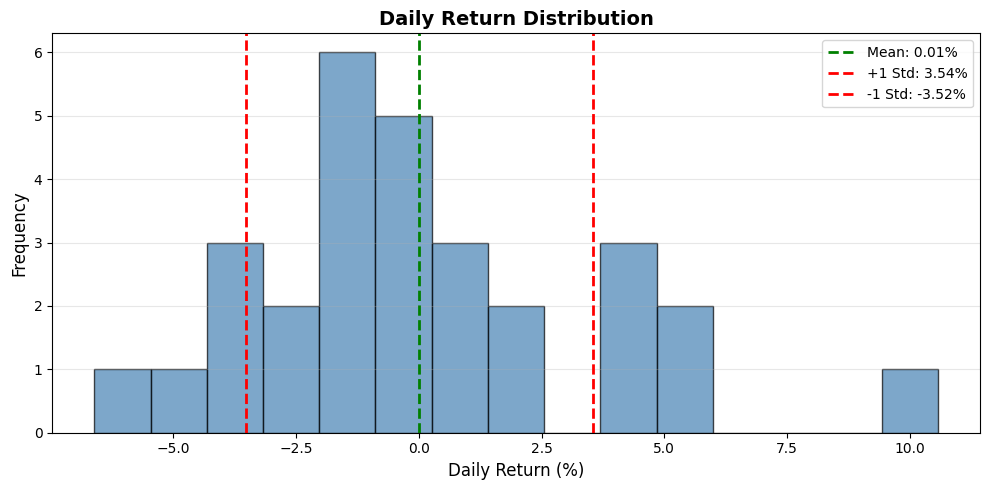

✅ 每日報酬率分佈圖繪製完成！


In [27]:
# 建立圖表
plt.figure(figsize=(10, 5))

# 繪製直方圖
plt.hist(daily_return * 100, bins=15, color='steelblue', edgecolor='black', alpha=0.7)

# 加上平均線和標準差線
mean_return = daily_return.mean() * 100
std_return = daily_return.std() * 100

plt.axvline(x=mean_return, color='green', linestyle='--', linewidth=2, label=f'Mean: {mean_return:.2f}%')
plt.axvline(x=mean_return + std_return, color='red', linestyle='--', linewidth=2, label=f'+1 Std: {mean_return + std_return:.2f}%')
plt.axvline(x=mean_return - std_return, color='red', linestyle='--', linewidth=2, label=f'-1 Std: {mean_return - std_return:.2f}%')

# 設定標題和標籤
plt.title('Daily Return Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Daily Return (%)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("✅ 每日報酬率分佈圖繪製完成！")

### 圖表 3：成交量長條圖

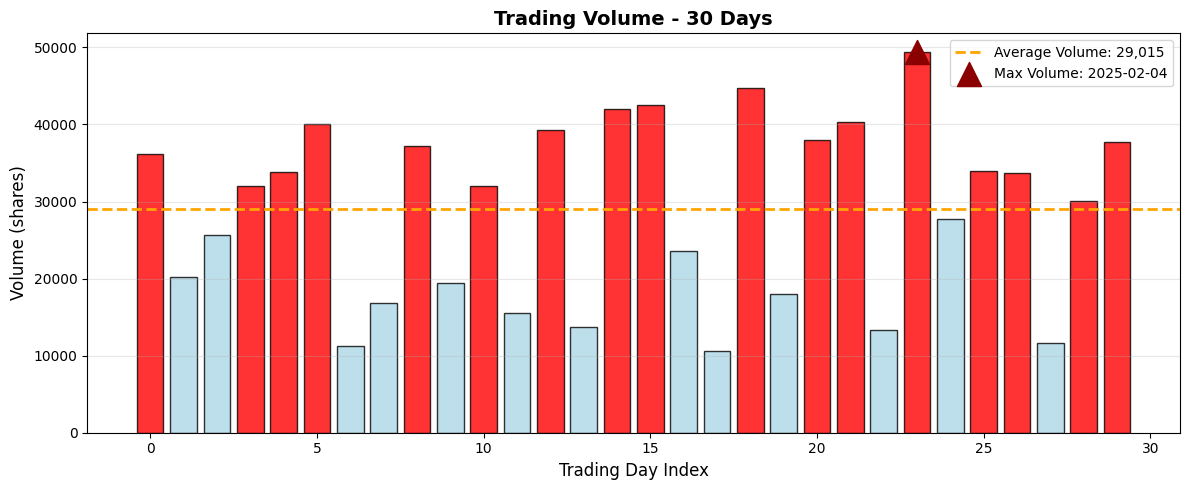

✅ 成交量長條圖繪製完成！


In [28]:
# 建立圖表
plt.figure(figsize=(12, 5))

# 繪製長條圖
colors = ['red' if v > volume.mean() else 'lightblue' for v in volume]
plt.bar(range(len(volume)), volume, color=colors, edgecolor='black', alpha=0.8)

# 加上平均線
plt.axhline(y=volume.mean(), color='orange', linestyle='--', linewidth=2, label=f'Average Volume: {volume.mean():,.0f}')

# 標記最大量
max_vol_idx = np.argmax(volume)
plt.scatter(max_vol_idx, volume[max_vol_idx], color='darkred', s=300, zorder=5, marker='^', label=f'Max Volume: {dates_loaded[max_vol_idx]}')

# 設定標題和標籤
plt.title('Trading Volume - 30 Days', fontsize=14, fontweight='bold')
plt.xlabel('Trading Day Index', fontsize=12)
plt.ylabel('Volume (shares)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("✅ 成交量長條圖繪製完成！")

## 🎉 專案完成！

### 你學到了什麼？

✅ **日期處理**：用 Python datetime 模組建立交易日清單，跳過週末

✅ **CSV 儲存**：處理混合型別資料（字串 + 數值），使用 `np.savetxt` 和格式化

✅ **CSV 載入**：用 `np.genfromtxt` 讀取，處理結構化陣列和二維陣列兩種情況

✅ **資料分離**：將日期和數值分離，方便後續處理

✅ **向量化分析**：
- 統計分析（mean, max, min, std）
- 索引搜尋（argmax, argmin）
- 切片運算（計算報酬率）
- 布林遮罩（篩選高波動日）

✅ **視覺化**：用 Matplotlib 繪製折線圖、直方圖、長條圖

---

### 下一步建議

1. **實際資料**：下載真實股價資料（例如 Yahoo Finance）
2. **技術指標**：實作 MA（移動平均）、MACD、RSI 等指標
3. **進階分析**：波動率分析、相關性分析、投資組合優化
4. **結合 Pandas**：學習如何在 NumPy 和 Pandas 間轉換，發揮各自優勢

---

### 💡 教學心得

這個專案展示了 NumPy 在真實場景中的應用：
- **不是每次都需要 Pandas**：純 NumPy 也能處理完整工作流程
- **理解底層很重要**：知道資料怎麼存、怎麼讀、怎麼運算
- **向量化思維**：避免 for-loop，用切片和遮罩解決問題

**恭喜完成專案！🎊**